In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from candas.utils import dilute, setup_paths

base_pth, code_pth, data_pth, rslt_pth, fig_pth = setup_paths()
# plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

### Blocker Dilution

* 100 μM blocker stock
* 100 nM primers (final)
* 0x, 1x, 2x, 3x, 5x, 10x, 20x, 30x blocker (final)
* 10x pre-dilution -> 1-30 μM intermediate dilutions
* 50 μL pre-dilution volume

In [3]:
targets = ['S075_WT', 'S075_SNV']
primers = ['FP001', 'FP0013', 'FP005', 'RP005']
blocker = 'L-MMMMx'
config = '2+2'

lg_copies = np.arange(8,0,-1)

In [4]:
n_rows = 16
n_cols = 24

ocols, orows = np.ogrid[0:n_rows, 0:n_cols]
mrows, mcols = np.mgrid[0:n_rows, 0:n_cols]

n_r = mrows.shape[0]
n_c = mrows.shape[1]

def make_df(plate_map, label):
    return pd.DataFrame(np.column_stack([mcols.flatten(), mrows.flatten(), plate_map.flatten()]), columns=['col', 'row', label])

def make_plate(plate_map, label, palette=None, **kwargs):
    df = make_df(plate_map, label)
    g = sns.relplot(data=df, x='col', y='row', hue=label, palette=palette, s=12**2, **kwargs)
    
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    xticks = np.arange(0,24)
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticks+1)
    yticks = np.arange(0,16)
    ax.set_yticks(yticks);
    ax.set_yticklabels([chr(ord('A')+tick) for tick in yticks]);
    for _, spine in g.ax.spines.items():
        spine.set_visible(True)
        
    return df

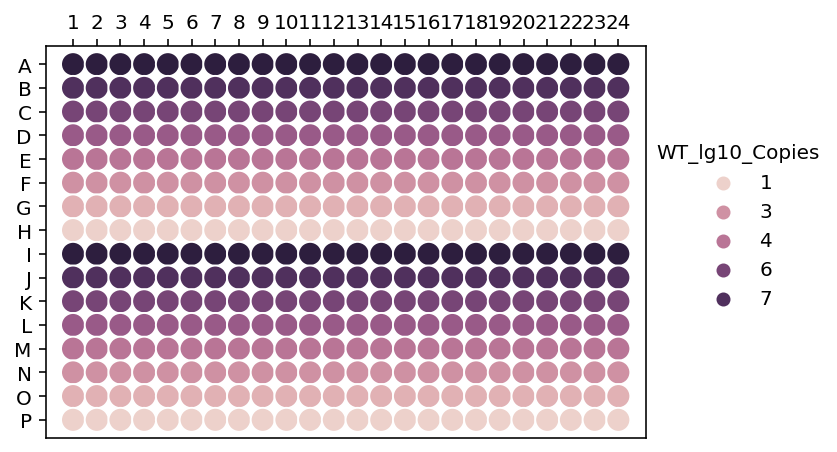

In [21]:
WT_copy_map = np.tile(lg_copies[:,None], [2, n_cols])
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
WT_copy_df = make_plate(WT_copy_map, 'WT_lg10_Copies')

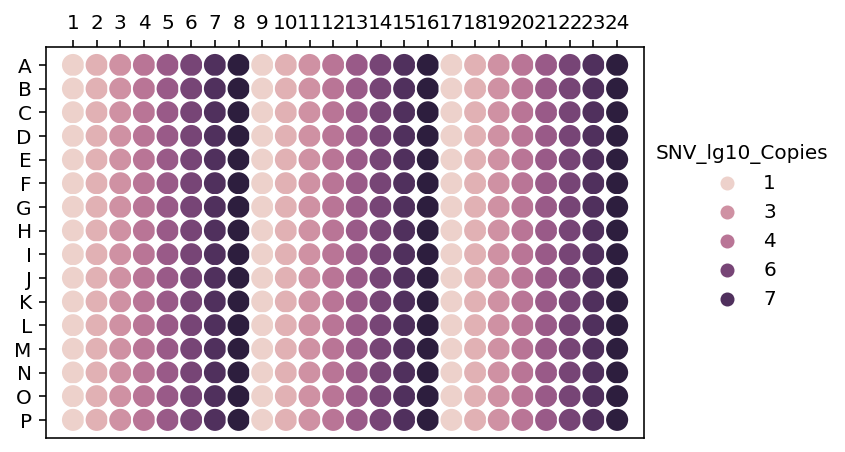

In [22]:
SNV_copy_map = np.tile(lg_copies[::-1], [n_rows, 3])
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
SNV_copy_df = make_plate(SNV_copy_map, 'SNV_lg10_Copies')

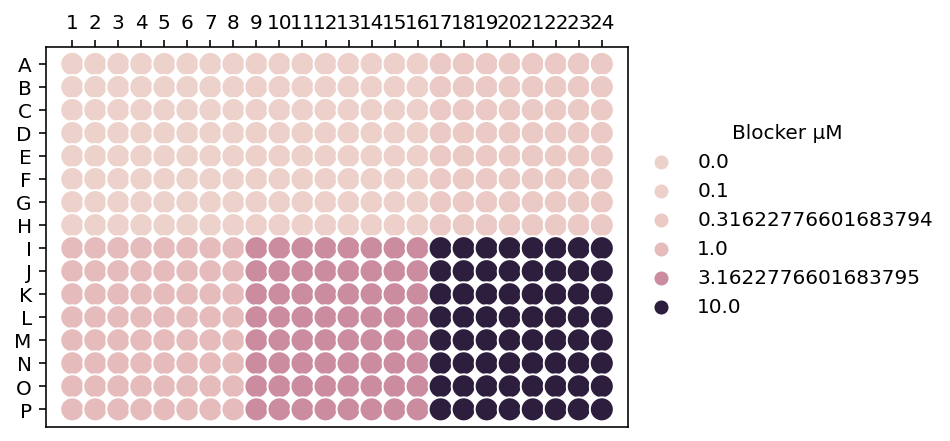

In [24]:
blocker_μMs = np.hstack([[0],10**np.array([-1, -0.5, 0, 0.5, 1])])

blocker_μM_map = np.kron(blocker_μMs.reshape(2,-1), np.ones([8,8]))
    
blocker_μM_df = make_plate(blocker_μM_map, 'Blocker μM')

# JG075D: L-MMMMx blocker 

In [25]:
experiment = 'JG075D'

rxns = (WT_copy_df
 .merge(SNV_copy_df)
 .merge(blocker_μM_df)
 .assign(
     Well = lambda df: df.col+df.row*24+1,
     WellName = lambda df: (df.row + ord('A')).map(chr)+(df.col+1).map(str),
     Sample = lambda df: experiment+'_'+df.Well.map('{:03d}'.format),
     Blocker = 'L-MMMMx'
 )
 .drop(columns=['col','row'])
)

rxns.to_csv(experiment + ' Plate Map.csv', index=False)
rxns

,WT_lg10_Copies,SNV_lg10_Copies,Blocker μM,Well,WellName,Sample,Blocker
0,8,1,0.0,1,A1,JG075D_001,L-MMMMx
1,8,2,0.0,2,A2,JG075D_002,L-MMMMx
2,8,3,0.0,3,A3,JG075D_003,L-MMMMx
3,8,4,0.0,4,A4,JG075D_004,L-MMMMx
4,8,5,0.0,5,A5,JG075D_005,L-MMMMx
...,...,...,...,...,...,...,...
379,1,4,10.0,380,P20,JG075D_380,L-MMMMx
380,1,5,10.0,381,P21,JG075D_381,L-MMMMx
381,1,6,10.0,382,P22,JG075D_382,L-MMMMx
382,1,7,10.0,383,P23,JG075D_383,L-MMMMx


In [28]:
filename = experiment + ' Plate Setup.txt'

with open(filename, 'w') as file:
    file.write('* Instrument Type = QuantStudio 6\n')
    file.write('* Passive Reference = ROX\n')
    file.write('[Sample Setup]\n')
    file.write('\t'.join(['Well', 'Target Name', 'Sample Name', 'Reporter', 'Quantity', 'Quencher', 'Task']) + '\n')
    
    for _, row in rxns.iterrows():
        file.write('\t'.join([str(row.Well), 'FAM', row.Sample, 'FAM', '', 'None', 'UNKNOWN']) + '\n')
        file.write('\t'.join([str(row.Well), 'HEX', row.Sample, 'HEX', '', 'None', 'UNKNOWN']) + '\n')